## Projeto Final - Álgebra Linear e Aplicações (SME0142)
Projeto confeccionado por Natan Sanches (11795680) e Álvaro José Lopes (10873365).

- **Objetivo e tematização:** A temática utilizada para confecção do projeto foi a de construção de um _pipeline_ dentro do contexto de Processamento de Linguagem Natural. Um texto bruto pôde ser analisado, permitindo um estudo sobre cada palavra individualmente e sua relação com os contextos em sua vizinhança; técnica usualmente chamada de _Word Embedding_. A partir desse estudo, é possível vetorizar palavras e utilizar técnicas de Álgebra Linear para manipulá-las.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from string import punctuation
from nltk.corpus import stopwords
from collections import Counter
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Leitura do texto central
Neste exemplo, utilizamos a romance Memórias Póstumas de Brás Cubas (clássico de Machado de Assis). O texto foi carregado a partir de um arquivo em disco, criando um _corpus_ (lista) de parágrafos disponíveis para manipulação.

In [2]:
# inputFile = "data/memorias-postumas-bras-cubas.txt"
# language = 'portuguese'
# with open(inputFile) as f:
#     corpus = f.readlines()
#     corpus = [paragraph.rstrip() for paragraph in corpus if paragraph != '\n']

In [3]:
inputFile = "data/memorias-postumas-bras-cubas.txt"
language = 'portuguese'
with open(inputFile) as f:
    corpus = f.readlines()
    
cleanedCorpus = []
fullSentence = ''
for sentence in corpus:
    if sentence == '\n':
        if 'CAPÍTULO' not in fullSentence:
            cleanedCorpus.append(fullSentence.replace('\n', ''))
        fullSentence = ''
    
    fullSentence += ' ' + sentence
corpus = cleanedCorpus

### 2. Pré-processamento do texto

Como em todo projeto envolvendo processamento de língua natural, é necessário que seja feito um pré-processamento que permite consistência na hora da análise textual. Dentre as técnicas de processamento realizadas, estão:

- Eliminação de conflitos case-sensitive, isto é, transformando todas as letras maiúsculas em minúsculas.
- Eliminação de caracteres não UTF-8, como uma maneira de preservar a consistência do texto.
- Eliminação de pontuações e objetos textuais de sinalização, uma vez que estes não serão importantes para a análise.
- Eliminação de _stop words_, ou palavras de parada (preposições, conjunções, etc), que não possuem contexto isolado.

In [4]:
punctranslation = str.maketrans(dict.fromkeys(punctuation))
setStopwords = set(stopwords.words(language))


# Realiza a tokenização e tratamento dos parágrafos do texto
def tokenize(corpus: str) -> list:
    corpusTokenized = []
    for paragraph in corpus:
        paragraph = paragraph.lower()                                       # Tratamento de case-sensitive
        paragraph = paragraph.encode('utf8', 'ignore').decode()             # Eliminação de caracteres fora de UTF-8
        paragraph = paragraph.translate(punctranslation)                    # Eliminação de pontuações
        tokens = [token for token in paragraph.split()                      # Eliminação de stopwords
                  if token not in setStopwords and token != '']
        corpusTokenized.append(list(filter(None, tokens)))
        
    return corpusTokenized
    
corpusTokenized = tokenize(corpus)

### 3. Contagem de unigramas do texto

Realiza, para cada parágrafo, a contagem de frequência de cada _token_ do texto.

In [8]:
unigrams = Counter()
for paragraph in corpusTokenized:
    for token in paragraph:
        unigrams[token] += 1

# Mapeamento de acesso (Token <-> Índice representativo)
token2index = {token: index for index, token in enumerate(unigrams.keys())}
index2token = {index: token for token, index in token2index.items()}

In [9]:
len(token2index)

10081

### 4. Contagem de bigramas do texto

Realiza, para cada parágrafo, a contagem dos bigramas presentes. Um bigrama representa a ocorrência de um par palavra-contexto, de maneira com que o contexto esteja dentro da janela de contexto. Nesse caso, o _range_ da janela de contexto foi de três palavras (para frente e para trás).

In [10]:
# Contador de bigramas, considerando uma determinada janela de contexto (nesse caso, 'gap'
# palavras antes e 'gap' palavras depois)
skipgrams = Counter()
gap = 5

for paragraph in corpusTokenized:
    tokens = [token2index[tok] for tok in paragraph]
    
    # Para cada palavra no parágrafo, realiza a análise dos contextos da vizinhança
    for indexWord, word in enumerate(paragraph):
        indexContextMin = max(0, indexWord - gap)
        indexContextMax = min(len(paragraph)-1, indexWord + gap)

        # Para cada contexto da vizinhança, crie um bigrama com a palavra central
        indexContexts = [index for index in range(indexContextMin, indexContextMax + 1) if index != indexWord]
        for indexContext in indexContexts:
            skipgram = (tokens[indexWord], tokens[indexContext])
            skipgrams[skipgram] += 1

# Exibição dos 10 bigramas mais comuns presentes no texto, considerando a janela de contexto estipulada
mostCommon = [(index2token[skipgram[0][0]], index2token[skipgram[0][1]], skipgram[1]) 
               for skipgram in skipgrams.most_common(10)]
mostCommon

[('quincas', 'borba', 66),
 ('borba', 'quincas', 66),
 ('d', 'plácida', 60),
 ('plácida', 'd', 60),
 ('alguma', 'coisa', 55),
 ('coisa', 'alguma', 55),
 ('lobo', 'neves', 51),
 ('neves', 'lobo', 51),
 ('tão', 'tão', 38),
 ('brás', 'cubas', 28)]

### 5. Criação da matriz de frequência termo-a-termo

Criação da matriz que relaciona dois _tokens_ (um bigrama) ao seu devido número de ocorrências.

In [15]:
# Mapeamento das entradas da matriz esparça de frequência entre os bigramas do texto
rowsMatrix = []
columnsMatrix = []
dataMatrix = []

for (token1, token2), skipgramCount in skipgrams.items():
    rowsMatrix.append(token1)
    columnsMatrix.append(token2)
    dataMatrix.append(skipgramCount)

wwMatrix = sparse.csr_matrix((dataMatrix, (rowsMatrix, columnsMatrix)))
wwMatrix

<10081x10081 sparse matrix of type '<class 'numpy.int64'>'
	with 264457 stored elements in Compressed Sparse Row format>

### 6. Criação da matriz PPMI

O PMI (Pointwise Mutual Information) é uma métrica que relaciona a probabilidade de ocorrência de uma palavra em conjunto com certo contexto, quando comparada à ocorrência de ambos isolados. Dessa forma, para uma palavra $w$ relacionada a um contexto $c$, o PMI dentre elas é dado pela relação

$$pmi(w, c) = \log{\left(\dfrac{P(w, c)}{P(w)P(c)}\right)}$$

onde $P(w, c)$ representa a probabilidade de ocorrência de determinada palavra em determinado contexto, $P(w)$ representa a probabilidade de ocorrência de determinada palavra no texto e $P(c)$ representa a probabilidade de ocorrência de determinado contexto no texto. Munidos dessa informação, podemos eliminar a possibilidade de $pmi(w, c)$ assumir valores negativos utilizando sua variação denominada de PPMI (Positive Pointwise Mutual Information), dada por

$$ppmi(w,c) = \textrm{max}(0,\ pmi(w, c)).$$

A matriz PPMI $[M]_{n \times n}$ é uma matriz quadrada que relaciona uma palavra $w$ e um contexto $c$ ao seu valor PPMI, de tal forma que $M(w, c) = ppmi(w, c)$.

In [16]:
# Número total de bigramas presente na matriz de frequência
numSkipgrams = wwMatrix.sum()

# Mapeamento das entradas da matriz PPMI
rowsIndex = []
columnsIndex = []
ppmiData = []

# Vetor de frequência total de cada palavra em todos os possíveis contextos
sumWords = np.array(wwMatrix.sum(axis=0)).flatten()

# Vetor de frequência total de cada contexto para todas as possíveis palavras
sumContexts = np.array(wwMatrix.sum(axis=1)).flatten()

for (tokenWord, tokenContext), skipgramCount in skipgrams.items():

    # Frequência de determinada palavra em determinado contexto
    # [#(w,c)]
    freqWordContext = skipgramCount

    # Frequência de determinada palavra em todos os contextos possíveis
    # [#(w)]
    freqWord = sumContexts[tokenWord]
    
    # Frequência de determinado contexto para todas as palavras possíveis
    # [#(c)]
    freqContext = sumWords[tokenContext]

    # Probabilidade de ocorrência de determinada palavra em determinado contexto
    # [P(w,c)]
    probWordContext = freqWordContext / numSkipgrams

    # Probabilidade de ocorrência de determinada palavra individualmente
    # [P(w)]
    probWord = freqWord / numSkipgrams

    # Probabilidade de ocorrência de determinado contexto individualmente
    # [P(c)]
    probContext = freqContext / numSkipgrams

    # Cálculo PPMI (Positive Pointwise Mutual Information)
    # [PPMI = max(0, log( P(w,c)/(P(w)P(c)) ))]
    PPMI = max(np.log2(probWordContext / (probWord * probContext)), 0)

    rowsIndex.append(tokenWord)
    columnsIndex.append(tokenContext)
    ppmiData.append(PPMI)

ppmiMatrix = sparse.csr_matrix((ppmiData, (rowsIndex, columnsIndex)))
ppmiMatrix

<10081x10081 sparse matrix of type '<class 'numpy.float64'>'
	with 264457 stored elements in Compressed Sparse Row format>

In [17]:
# # Número total de bigramas presente na matriz de frequência
# numSkipgrams = wwMatrix.sum()

# # Mapeamento das entradas da matriz PPMI
# rowsIndex = []
# columnsIndex = []
# ppmiData = []
# sppmiData = []

# # Vetor de frequência total de cada palavra em todos os possíveis contextos
# sumWords = np.array(wwMatrix.sum(axis=0)).flatten()

# # Vetor de frequência total de cada contexto para todas as possíveis palavras
# sumContexts = np.array(wwMatrix.sum(axis=1)).flatten()

# #smoothing
# alpha = 0.75
# sumOverWordsAlpha = sumWords**alpha
# sumAllWordsAlpha = np.sum(sumOverWordsAlpha)




# for (tokenWord, tokenContext), skipgramCount in skipgrams.items():

#     # Frequência de determinada palavra em determinado contexto
#     # [#(w,c)]
#     freqWordContext = skipgramCount

#     # Frequência de determinada palavra em todos os contextos possíveis
#     # [#(w)]
#     freqWord = sumContexts[tokenWord]
    
#     # Frequência de determinado contexto para todas as palavras possíveis
#     # [#(c)]
#     freqContext = sumWords[tokenContext]

#     # Probabilidade de ocorrência de determinada palavra em determinado contexto
#     # [P(w,c)]
#     probWordContext = freqWordContext / numSkipgrams

#     # Probabilidade de ocorrência de determinada palavra individualmente
#     # [P(w)]
#     probWord = freqWord / numSkipgrams

#     # Probabilidade de ocorrência de determinado contexto individualmente
#     # [P(c)]
#     probContext = freqContext / numSkipgrams
    
#     nca = sumOverWordsAlpha[tokenContext]
#     Pca = nca/sumAllWordsAlpha

#     # Cálculo PPMI (Positive Pointwise Mutual Information)
#     # [PPMI = max(0, log( P(w,c)/(P(w)P(c)) ))]
#     PPMI = max(np.log2(probWordContext / (probWord * probContext)), 0)
#     SPPMI = max(np.log2(probWordContext/ (probWord * Pca)), 0)

#     rowsIndex.append(tokenWord)
#     columnsIndex.append(tokenContext)
#     ppmiData.append(PPMI)
#     sppmiData.append(SPPMI)

# ppmiMatrix = sparse.csr_matrix((sppmiData, (rowsIndex, columnsIndex)))


### 7. Fatoração matricial usando SVD (Singular Value Decomposition)

A Decomposição por Valor Singular (SVD) é uma maneira possível de fatorarmos a matriz esparça de PPMI, de maneira que possamos deixá-la mais densa. Uma matriz $[M]_{m \times n}$ pode ser fatorada da forma

$$M = U \Sigma V^*$$

onde $[U]_{m \times m}$ é uma matriz unitária, $[\Sigma]_{m \times n}$ é uma matriz retangular diagonal e $[V^*]_{n \times n}$ é uma matriz unitária (dita conjugada transposta de $V$). As entradas diagonais de $\Sigma$ são os ditos valores singulares de $M$, enquanto o espaço-coluna de $U$ e $V$ contém os ditos vetores singulares à esquerda e à direita de $M$, respectivamente. 

In [18]:
from scipy.sparse.linalg import svds as SVD

# Dimensão proposta da matriz de valores singulares produzida pelo SVD
# [Hiperparâmetro]
embeddingSize = 50

U, D, V = SVD(ppmiMatrix, embeddingSize)

# Normalização das matrizes de vetores singulares produzidas pelo SVD
Unorm = U / np.sqrt(np.sum(U*U, axis=1, keepdims=True))
Vnorm = V / np.sqrt(np.sum(V*V, axis=1, keepdims=True))

wordVecs = Unorm

### 8. Visualização de palavras similares por similaridade por cosseno

A similaridade por cosseno é uma métrica de similaridade entre vetores que consiste em comparar o ângulo entre eles. Para dois vetores $u$ e $v$, a similaridade por cosseno pode ser descrita pela relação

$$cos(\theta) = \dfrac{u \cdot v}{||u||\ ||v||} = \dfrac{\sum_{i=1}^n u_i v_i}{\sqrt{\sum_{i=1}^n u_i^{\ 2}}\ \sqrt{\sum_{i=1}^n v_i^{\ 2}}}$$

de tal forma que $\theta$ descreve o ângulo entre esses vetores e $u \cdot v$ é o produto escalar entre eles. Essa métrica de similiadade pode ser utilizada, em palavras vetorizadas, para medir o índice de relação entre uma palavra e um contexto.


In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Cálculo dos 10 contextos mais similares a dada palavra utilizando a matriz de Word Embedding
def wordsSimilarity(word, matrix, n):
    wordIndex = token2index[word]

    # Resgate do vetor representante de determinada palavra
    if isinstance(matrix, sparse.csr_matrix):
        wordVec = matrix.getrow(wordIndex)
    else:
        wordVec = matrix[wordIndex:wordIndex+1, :]

    # Cálculo da similidade (similaridade de vetores por cosseno)
    similarity = cosine_similarity(matrix, wordVec).flatten()
    sortedIndexes = np.argsort(-similarity)

    # Retorno dos n contextos mais similares a dada palavra
    similarityContextScores = [(index2token[sortedIndex], similarity[sortedIndex]) 
                                for sortedIndex in sortedIndexes[:n+1] 
                                if index2token[sortedIndex] != word]

    return similarityContextScores

def wordSimilarityReport(word, matrix, n=5):
    print(f'\'{word}\'\t Frequência total: {unigrams[word]}', end='\n\t')

    similarityContextScores = wordsSimilarity(word, matrix, n)
    for context, similarity in similarityContextScores:
        print(f'(\'{context}\', {similarity})', end='\t')
    

In [20]:
token2index['defunto']

144

In [21]:
examples = ['defunto', 'autor', 'brás', 'coimbra', 'flagelos', 'alegria', 'shakespeare', 'homem', 'luxo',
    'filósofo', 'festa', 'olhos', 'guerra', 'ensino', 'borba', 'autor', 'leitor']
for word in examples:
    wordSimilarityReport(word, wordVecs)
    print('\n'+'---'*20)

'defunto'	 Frequência total: 6
	('advirta', 0.676682234927071)	('lorpa', 0.6308017421431621)	('cainho', 0.6180469665573761)	('campa', 0.6132712023548362)	('autor', 0.6039702310183456)	
------------------------------------------------------------
'autor'	 Frequência total: 6
	('campa', 0.8015306670497718)	('consular', 0.6682211057473031)	('oração', 0.6616975498015217)	('cxxix', 0.658982017618673)	('segunda', 0.6581954536921043)	
------------------------------------------------------------
'brás'	 Frequência total: 30
	('cubas', 0.9590249110840328)	('cumprimenta', 0.9334752781622581)	('conhece', 0.9327818045344284)	('fundou', 0.9317088514677981)	('palerma', 0.9306099526251349)	
------------------------------------------------------------
'coimbra'	 Frequência total: 5
	('esperavame', 0.7756773427023416)	('primou', 0.7733086889708405)	('desembarquei', 0.7597868505173543)	('matérias', 0.7549887768954255)	('estudou', 0.7524382032022116)	
-----------------------------------------------------

In [22]:
# Com lemmatização
examples = ['defunto', 'brás', 'coimbra', 'flagelo', 'alegria', 'shakespeare', 'homem',
    'filósofo', 'festa', 'olho', 'guerra', 'faculdade', 'borba', 'leitor']
for word in examples:
    wordSimilarityReport(word, wordVecs)
    print('\n'+'---'*20)

'defunto'	 Frequência total: 6
	('advirta', 0.676682234927071)	('lorpa', 0.6308017421431621)	('cainho', 0.6180469665573761)	('campa', 0.6132712023548362)	('autor', 0.6039702310183456)	
------------------------------------------------------------
'brás'	 Frequência total: 30
	('cubas', 0.9590249110840328)	('cumprimenta', 0.9334752781622581)	('conhece', 0.9327818045344284)	('fundou', 0.9317088514677981)	('palerma', 0.9306099526251349)	
------------------------------------------------------------
'coimbra'	 Frequência total: 5
	('esperavame', 0.7756773427023416)	('primou', 0.7733086889708405)	('desembarquei', 0.7597868505173543)	('matérias', 0.7549887768954255)	('estudou', 0.7524382032022116)	
------------------------------------------------------------
'flagelo'	 Frequência total: 3
	('estigmada', 0.8522191638632841)	('devastara', 0.8448597592831705)	('inimiga', 0.7325149479572063)	('apareciame', 0.710344563037053)	('travessos', 0.7041247266396246)	
--------------------------------------

### 9. Visualizando as palavras através de um ScatterPlot interativo

Para que seja possível plotar as palavras é preciso realizar uma redução de dimensionalidade nos dados, uma vez que a dimensão dos vetores de *embedding* é maior do que dois.

Serão testados dois métodos de redução de dimensionalidade:
* PCA (*Principal Component Analysis*): Promove uma transformação linear ortogonal nos dados, projetando-os em uma nova base que preserva o máximo possível da variância dos dados. Dessa forma, ao longo da primeira coordenada (primeira componente) tem-se a maior variância e, analogamente, ao longo da segunda coordenada (segunda componente) tem-se a segunda maior variância.

* t-SNE (*T-distributed Stochastic Neighbor Embedding*): Método estatístico que estabelece uma distribuição de probabilidade para todos os pares de pontos de tal forma que para pontos similares (pontos próximos a partir de uma dada métrica) serão atribuídas uma alta probabilidade, enquanto para pontos dissimilares (pontos distantes) serão atribuídas uma baixa probabilidade. A métrica escolhida será o cosseno.

Após a redução de dimensionalidade será possível plotar as palavras em um espaço euclideano de duas dimensões, em que cada ponto representa uma palavra.

In [23]:
def createWordVecsDataFrame(reducedWordVecs, token2index):
    # Criando um dicionário para cada palavra e seu respectivo vetor após redução de dimensionalidade
    dictReducedWordVecs = {}
    for word, index in token2index.items():
        dictReducedWordVecs[word] = reducedWordVecs[index]

    # Instanciando o dataframe a partir do dicionario criado acima
    dfWordVecs = pd.DataFrame.from_dict(
        data = dictReducedWordVecs,
        orient = 'index',
        columns = ['x', 'y']
    )
    dfWordVecs['word'] = dfWordVecs.index
    
    return dfWordVecs

In [24]:
# Configurando a ferramenta interativa com o notebook
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()


def interativePlot(df, title = None, xlabel = None, ylabel = None):
    # Instancia uma ColumnDAtaSource do Bokeh usando o dataframe
    data = ColumnDataSource(df)

    # Cria o plot e configura:
    # título, dimensões e ferramentas interativas
    plot = figure(
        title= title,
        plot_width=800,
        plot_height=800,
        tools=(
            'pan, wheel_zoom, box_zoom,'
            'box_select, reset',
            HoverTool(tooltips = '@word')
            ),
        active_scroll='wheel_zoom',
        x_axis_label = xlabel,
        y_axis_label = ylabel
        )

    # Desenha os circulos representado as palavras
    plot.circle(
        'x',
        'y',
        source=data,
        color='blue',
        line_alpha=0.2,
        fill_alpha=0.1,
        size=10,
        hover_line_color='black'
        )

    # Configuração de outros detalhes visuais
    plot.xaxis.visible = False
    plot.yaxis.visible = False
    plot.grid.grid_line_color = None
    plot.outline_line_color = None


    show(plot);


Loading BokehJS ...

In [25]:
from sklearn.decomposition import PCA

# Realizando redução de dimensão com PCA
pca = PCA(n_components = 2)
reducedWordVecs = pca.fit_transform(wordVecs)
print(pca.explained_variance_)

dfWordVecs = createWordVecsDataFrame(reducedWordVecs, token2index)
interativePlot(dfWordVecs.sample(1500), title = 'Word Vecs (PCA)')

[0.02281797 0.02260608]


In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(metric = 'cosine')
reducedWordVecs = tsne.fit_transform(wordVecs)

dfWordVecs = createWordVecsDataFrame(reducedWordVecs, token2index)
interativePlot(dfWordVecs.sample(1500), title = 'Word Vecs (TSNE)')

### 10. Visualização a partir de um agrupamento hierárquico das palavras

Também podemos visualizar o resultado através de um agrupamento hierárquico de um conjunto de palavras. 

A hierarquia será obtida através do agrupamento aglomerativo, no qual, inicialmente, cada ponto possuirá seu próprio *cluster* e cada par de *clusters* próximos serão agrupados a medida que a hierarquia aumenta. 

Sejam dois agrupamentos $S$ e $T$, a distância entre os cluster será dada por $d(S,T)$. Quando $S$ e $T$ são agrupados em um único cluster $U$, então $S$ e $T$ serão removidos e substituídos por $U$. Ao final do algoritmo restará um único cluster, o qual será a raiz da hierarquia.

Seja o cluster $U$ de $dim(U) = n$ formado pelos pontos $\{u_{0}, u_{1}, ..., u_{i}, ..., u_{n-1}\}$ e seja $V$ um outro *cluster* $V$ de $dim(V) = m$ formado pelos pontos $\{v_{0}, v_{1}, ..., v_{j}, ..., v_{m-1}\}$, a distância entre os clusters $U$ e $V$ será dada por:

$$d(U,V) = \sum_{i,j}^{n,m} \dfrac{d(u_{i}, v_{j})}{n*m}$$

em que,

$$d(u_{i}, v_{j}) = \dfrac{u \cdot v}{||u||\ ||v||}$$

Ou seja, a distância entre os pontos de um cluster será dada pela métrica de distância cosseno e a distância entre os cluster será dada pela média das distâncias entre os pontos de um par de *clusters*. Os pares de clusters a serem agrupados serão aqueles de menor distância.

Em seguida, os agrupamentos hierárquicos serão visualizado através de um dendograma.

In [27]:
# Cria um conjunto de palavras considerando as de referência juntamente com as suas n mais similares
def sampleWords(referenceWords, wordVecs, n = 5):
    sample = set()
    for word in referenceWords:
        sample.add(word)
        similarityContextScores = wordsSimilarity(word, wordVecs, n)
        for context, _ in similarityContextScores:
            sample.add(context)
            
    return sample

In [28]:
# Escolhe as palavras que serão usadas como referência para obter uma amostra
referenceWords = [
    'defunto', 'brás', 'romance', 'coimbra', 'flagelos', 'alegria', 'shakespeare', 'homem', 'luxo',
    'filósofo', 'festa', 'olhos', 'ontem', 'guerra', 'ensino', 'leitor'
]

sample = sampleWords(referenceWords, wordVecs)

# Obtem os respectivos Word Embeddings
embeddings = [wordVecs[token2index[word]] for word in sample]

In [29]:
# # Escolhe as palavras que serão usadas como referência para obter uma amostra
# referenceWords = [
#     'defunto', 'brás', 'romance', 'coimbra', 'flagelo', 'alegria', 'shakespeare', 'homem',
#     'filósofo', 'festa', 'olho', 'ontem', 'guerra', 'faculdade'
# ]

# sample = sampleWords(referenceWords, wordVecs)

# # Obtem os respectivos Word Embeddings
# embeddings = [wordVecs[token2index[word]] for word in sample]

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
def plotDendogram(words, embeddings, title = None, xlabel = None, ylabel = None, figsize = (25,5)):
    plt.figure(figsize = figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # clustering do tipo aglomerativo, usando como critério de agrupamento 
    # a média da distância entre os pontos de um par de cluster, usando o cosseno 
    # como métrica de distância entre os pontos
    link = linkage(embeddings, method = 'average', metric = 'cosine')
    
    dendrogram(
        link,
        labels = words,
        leaf_rotation=90.,  
        leaf_font_size=10.,  
        orientation='top',
    )
    
    plt.show()
    

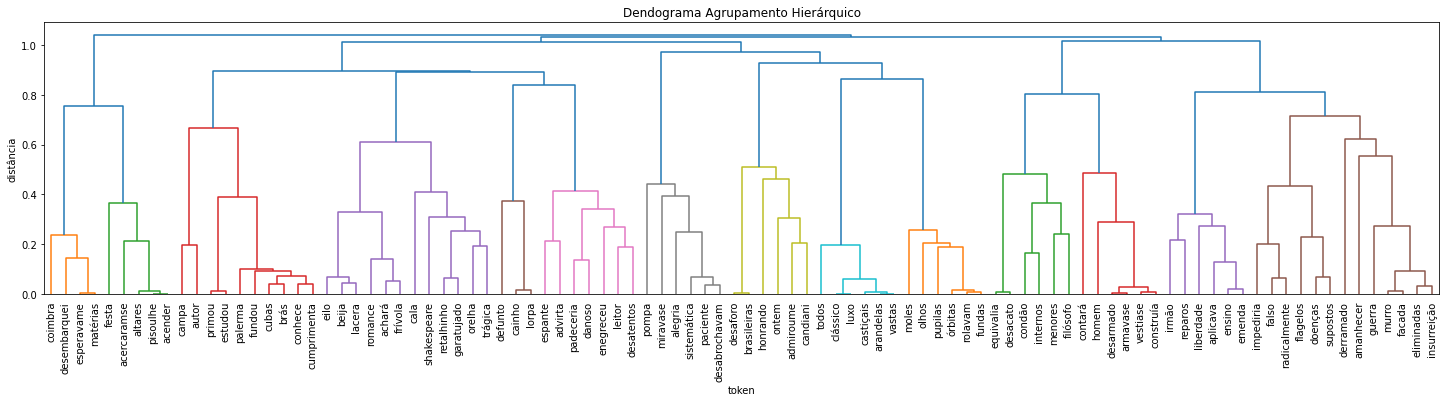

In [31]:
plotDendogram(list(sample), embeddings, title = 'Dendograma Agrupamento Hierárquico', 
              ylabel = 'distância', xlabel = 'token')

In [32]:
len(token2index)

10081